In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import matplotlib.pyplot as plt

import numpy as np

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Predictive
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import norm

from torch import tensor

random_seed = 9939
random_key = random.PRNGKey(random_seed)

Inv_Cumulative_Normal = norm.ppf

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

/home/akotlar/tada/project/mvl2/genData2.py:193: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  alt_counts = tensor(alt_counts)


tensor([9.7601e-05, 9.7601e-05, 9.7601e-05, 9.7601e-05], dtype=torch.float64)
mean affects 1 tensor([9.6533e-05, 9.7538e-05, 1.9509e-04, 1.9509e-04], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.8329e-05, 3.1126e-04, 2.0507e-04, 6.3633e-04], dtype=torch.float64)
std affects 2 tensor([9.9379e-05, 3.2670e-04, 2.1413e-04, 7.0302e-04], dtype=torch.float64)
mean affects 3 tensor([9.5805e-05, 2.9412e-04, 9.7828e-05, 2.9412e-04], dtype=torch.float64)
std affects 3 tensor([0.0001, 0.0003, 0.0001, 0.0003], dtype=torch.float64)
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


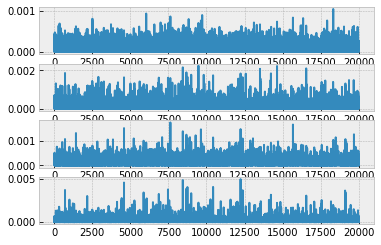

In [3]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)
sim_data["PVDs"].mean(0)

print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))

fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [4]:
random_key, _random_key = random.split(random_key)

run_params = {
    "data": sim_data["alt_counts"].numpy(),
    "n_cases": sim_params["n_cases"].numpy(),
    "n_ctrls": sim_params["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

mcmc_rs = run_until_enough(random_key=_random_key, run_params=run_params)

best_chain_rs, statistics_rs = select_best_chain(mcmc_rs)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_rs, best_probs_rs, _, _ = get_parameters(best_chain_rs)
H_rs, mean_df_rs = get_assumed_order_for_2(best_probs_rs)
best_weights_rs, best_probs_rs, best_betas_rs, best_dirichlet_concentrations_rs = ordered_statistics([best_chain_rs], H_rs)

print("best chain's weight mean", best_weights_rs.mean(0))
print("best chain's probs mean", best_probs_rs.mean(0))

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.69      0.02      0.69      0.65      0.72   1334.01      1.00
                   beta[1]      0.16      0.03      0.16      0.11      0.21   1828.84      1.00
                   beta[2]      0.45      0.04      0.45      0.37      0.52   1539.07      1.00
dirichlet_concentration[0]      3.09      1.29      2.93      0.97      5.06   3080.95      1.00
dirichlet_concentration[1]      1.90      0.83      1.80      0.65      3.23   3435.44      1.00
dirichlet_concentration[2]      1.67      0.71      1.57      0.55      2.74   3255.57      1.00
dirichlet_concentration[3]      1.00      0.47      0.93      0.25      1.70   4195.42      1.00
                probs[0,0]      0.60      0.00      0.60      0.60      0.61   1846.98      1.00
                probs[0,1]      0.18      0.00      0.18      0.17      0.18   5016.33      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.15   1519.05      1.00
                   beta[1]      0.06      0.01      0.06      0.04      0.07   1726.68      1.00
                   beta[2]      0.82      0.01      0.82      0.80      0.85   1784.59      1.00
dirichlet_concentration[0]      3.10      1.27      2.96      1.06      4.94   3464.42      1.00
dirichlet_concentration[1]      1.90      0.81      1.79      0.60      3.10   3442.57      1.00
dirichlet_concentration[2]      1.68      0.71      1.59      0.56      2.74   3907.03      1.00
dirichlet_concentration[3]      1.00      0.45      0.94      0.30      1.68   4080.40      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2200.75      1.00
                probs[0,1]      0.14      0.01      0.14      0.13      0.15   2891.74      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.15   1476.42      1.00
                   beta[1]      0.78      0.01      0.78      0.76      0.79   2011.69      1.00
                   beta[2]      0.75      0.05      0.76      0.68      0.83   1797.14      1.00
dirichlet_concentration[0]      3.12      1.28      2.95      1.06      5.00   3053.53      1.00
dirichlet_concentration[1]      1.93      0.83      1.83      0.66      3.21   3635.72      1.00
dirichlet_concentration[2]      1.70      0.74      1.61      0.56      2.80   3797.97      1.00
dirichlet_concentration[3]      1.03      0.46      0.97      0.32      1.74   4021.84      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2041.01      1.00
                probs[0,1]      0.14      0.01      0.14      0.14      0.16   3366.83      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [00:40<00:00, 148.32it/s, 7 steps of size 2.45e-01. acc. prob=0.92] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.16   1339.02      1.00
                   beta[1]      0.78      0.01      0.78      0.76      0.79   1971.01      1.00
                   beta[2]      0.75      0.04      0.76      0.68      0.82   2031.03      1.00
dirichlet_concentration[0]      3.11      1.29      2.97      1.08      5.11   2834.77      1.00
dirichlet_concentration[1]      1.92      0.83      1.82      0.58      3.17   3034.47      1.00
dirichlet_concentration[2]      1.68      0.72      1.57      0.56      2.79   2984.52      1.00
dirichlet_concentration[3]      1.01      0.46      0.95      0.27      1.69   3714.60      1.00
                probs[0,0]      0.48      0.01      0.48      0.47      0.50   1777.82      1.00
                probs[0,1]      0.14      0.01      0.14      0.14      0.16   3514.02      1.00
                probs[0,2]   

In [5]:
print("best chain's weight mean", best_weights_rs.mean(0))
print("best chain's probs mean", best_probs_rs.mean(0))

best chain's weight mean [0.6862928  0.14512138 0.11832162 0.05026502]
best chain's probs mean [[0.60180473 0.17528495 0.17678191 0.04612771]
 [0.4022304  0.3621522  0.13101432 0.10460314]
 [0.48147988 0.14393406 0.29689336 0.0776924 ]
 [0.31456763 0.30347282 0.20936799 0.17259118]]


In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv')

#df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.022515,0.02302,0.001295])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_K": 4,
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8 = run_until_enough(random_key=_random_key, run_params=run_params_dave)
best_chain, statistics = select_best_chain(mcmc_dave_2k_8k_gamma8)
display(statistics)
del mcmc_dave_2k_8k_gamma8

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean',best_probs_mean_across_mcmc_samples)
display('best_probs sample mean', best_weights_mean_across_mcmc_samples)

display(mean_df)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.01      0.09      0.07      0.11   1537.92      1.00
                   beta[1]      0.84      0.02      0.84      0.80      0.88   1323.98      1.00
                   beta[2]      0.74      0.07      0.74      0.62      0.86   1254.08      1.00
dirichlet_concentration[0]      6.66      1.04      6.60      4.91      8.26   4365.94      1.00
dirichlet_concentration[1]      0.61      0.26      0.57      0.17      0.98   3699.23      1.00
dirichlet_concentration[2]      0.71      0.29      0.67      0.25      1.17   3909.13      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.05      0.44   3216.15      1.00
                probs[0,0]      0.88      0.00      0.88      0.87      0.89   1602.87      1.00
                probs[0,1]      0.05      0.00      0.05      0.04      0.05    887.77      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.78   1496.35      1.00
                   beta[1]      0.39      0.06      0.39      0.28      0.49   1287.16      1.00
                   beta[2]      0.74      0.07      0.74      0.63      0.86    839.28      1.00
dirichlet_concentration[0]      6.63      1.00      6.57      4.95      8.19   3918.35      1.00
dirichlet_concentration[1]      0.61      0.26      0.57      0.20      1.02   2233.83      1.00
dirichlet_concentration[2]      0.72      0.30      0.68      0.22      1.16   5054.12      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.06      0.45   3953.46      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   1887.62      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   2019.85      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.11      0.02      0.11      0.09      0.14   1692.61      1.00
                   beta[1]      0.10      0.02      0.10      0.07      0.13   1464.67      1.00
                   beta[2]      0.06      0.02      0.06      0.03      0.09   1143.24      1.00
dirichlet_concentration[0]      6.67      1.03      6.61      4.99      8.31   4562.97      1.00
dirichlet_concentration[1]      0.63      0.27      0.60      0.21      1.05   4311.95      1.00
dirichlet_concentration[2]      0.72      0.29      0.68      0.26      1.16   4472.67      1.00
dirichlet_concentration[3]      0.27      0.13      0.25      0.07      0.46   4017.93      1.00
                probs[0,0]      0.91      0.00      0.91      0.90      0.91   1724.17      1.00
                probs[0,1]      0.07      0.00      0.07      0.06      0.07   1599.01      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [01:28<00:00, 68.17it/s, 63 steps of size 1.08e-01. acc. prob=0.81] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.79   1136.30      1.00
                   beta[1]      0.46      0.05      0.46      0.37      0.55   1446.14      1.00
                   beta[2]      0.69      0.10      0.70      0.53      0.85    845.14      1.00
dirichlet_concentration[0]      6.64      1.03      6.59      5.01      8.39   3650.52      1.00
dirichlet_concentration[1]      0.62      0.25      0.58      0.25      1.02   3478.47      1.00
dirichlet_concentration[2]      0.71      0.29      0.67      0.25      1.16   3675.22      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.06      0.46   3202.91      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   1436.67      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   1679.03      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.900488,0.108978,2282779.75,0.0
2,0.0,0.897254,0.111298,2282767.50,2.0
1,1.0,0.869522,0.146769,2282762.50,1.0
3,1.0,0.813319,0.209910,2282762.50,3.0


'best_probs sample mean'

array([[0.954266  , 0.02247979, 0.02185375, 0.00139964],
       [0.9221485 , 0.00877925, 0.06783286, 0.00124008],
       [0.9045813 , 0.06626486, 0.02459602, 0.00455859],
       [0.8807757 , 0.04540931, 0.06677187, 0.00704321]], dtype=float32)

'best_probs sample mean'

array([0.75783503, 0.03937223, 0.1099399 , 0.09285133], dtype=float32)

,"P(~D|V,H)","P(D2|V,H)","P(D1|V,H)","P(D12|V,H)"
H12,0.88,0.0450,0.067,0.0070
H0,0.95,0.0220,0.022,0.0014
H2,0.90,0.0660,0.025,0.0046
H1,0.92,0.0088,0.068,0.0012


In [8]:
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean',best_probs_mean_across_mcmc_samples)
display('best_probs sample mean', best_weights_mean_across_mcmc_samples)

display(mean_df)

'best_probs sample mean'

array([[0.954266  , 0.02247979, 0.02185375, 0.00139964],
       [0.9221485 , 0.00877925, 0.06783286, 0.00124008],
       [0.9045813 , 0.06626486, 0.02459602, 0.00455859],
       [0.8807757 , 0.04540931, 0.06677187, 0.00704321]], dtype=float32)

'best_probs sample mean'

array([0.75783503, 0.03937223, 0.1099399 , 0.09285133], dtype=float32)

,"P(~D|V,H)","P(D2|V,H)","P(D1|V,H)","P(D12|V,H)"
H12,0.88,0.0450,0.067,0.0070
H0,0.95,0.0220,0.022,0.0014
H2,0.90,0.0660,0.025,0.0046
H1,0.92,0.0088,0.068,0.0012


In [25]:
H_based_on_pis = [0,3,2,1]
print("H", H)
print("H_based_on_pis", H_based_on_pis)

print("best_weights.mean(0)", best_weights.mean(0))

print("best_weights.mean(0)[H]", best_weights.mean(0)[H])

print("best_weights.mean(0)[H_based_on_pis]", best_weights.mean(0)[H_based_on_pis])

print("\nbest_probs.mean(0)", best_probs.mean(0))
print("best_probs.mean(0)[H]", best_probs.mean(0)[H])
print("best_probs.mean(0)[H_based_on_pis]", best_probs.mean(0)[H_based_on_pis])

PD_V_H_P_H_across_samples = np.multiply(best_probs, best_weights.reshape(*best_weights.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H])
print("ordered PD|Vs based on H_based_on_pis", PD_V_H_P_H_mean[H_based_on_pis])
        
PD_V = PD_V_H_P_H_mean[H_based_on_pis].sum(1)
display("PD|V", PD_V)
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

H [1 3 2 0]
H_based_on_pis [0, 3, 2, 1]
best_weights.mean(0) [0.75783503 0.03937223 0.1099399  0.09285133]
best_weights.mean(0)[H] [0.03937223 0.09285133 0.1099399  0.75783503]
best_weights.mean(0)[H_based_on_pis] [0.75783503 0.09285133 0.1099399  0.03937223]

best_probs.mean(0) [[0.954266   0.02247979 0.02185375 0.00139964]
 [0.9221485  0.00877925 0.06783286 0.00124008]
 [0.9045813  0.06626486 0.02459602 0.00455859]
 [0.8807757  0.04540931 0.06677187 0.00704321]]
best_probs.mean(0)[H] [[0.9221485  0.00877925 0.06783286 0.00124008]
 [0.8807757  0.04540931 0.06677187 0.00704321]
 [0.9045813  0.06626486 0.02459602 0.00455859]
 [0.954266   0.02247979 0.02185375 0.00139964]]
best_probs.mean(0)[H_based_on_pis] [[0.954266   0.02247979 0.02185375 0.00139964]
 [0.8807757  0.04540931 0.06677187 0.00704321]
 [0.9045813  0.06626486 0.02459602 0.00455859]
 [0.9221485  0.00877925 0.06783286 0.00124008]]

PD_V_H_P_H_mean [[7.2317046e-01 1.7040182e-02 1.6565468e-02 1.0611174e-03]
 [3.6299128e-02 3.96

'PD|V'

array([0.75783724, 0.09285131, 0.10994001, 0.03937228], dtype=float32)

'rr'

array([ 4.12397561,  4.77584741, 30.4033052 ])

In [10]:
PD_V[1:4].sum()

0.96062857

In [11]:
df

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,29,2,1,0
1,30,1,0,0
2,47,3,1,0
3,32,2,2,0
4,38,0,2,0
...,...,...,...,...
19995,34,1,2,0
19996,41,1,2,0
19997,30,0,1,0
19998,34,1,1,0


In [32]:
df.sum(1)

0        32
1        31
2        51
3        36
4        40
         ..
19995    37
19996    44
19997    31
19998    36
19999    48
Length: 20000, dtype: int64

In [37]:
(df['Unaffected_Affected'] / df.sum(1)).mean()

0.02887262097401098

In [34]:
(df['Affected_Unaffected'] / df.sum(1)).mean(0)

0.028136070468503204

In [35]:
(df['Unaffected_Affected'] / df.sum(1)).mean(0)

0.02887262097401098

In [ ]:
(df['Unaffected_Affected'] / df.sum(1)).mean(0)

In [38]:
(df['Affected_Affected'] / df.sum(1)).mean(0)

0.0022532867884159005

In [28]:
df['Affected_Unaffected'].mean(0)

1.12425

In [30]:
df['Affected_Affected'].mean(0)

0.0907

In [39]:
    P_D1_A1 = PD_V[1]
    P_D2_A1 = PD_V[2]
    print("P_D1_A1", P_D1_A1)
    print("P_D2_A1", P_D2_A1)
    q = 1e-4
    p = 1-q

    #Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
    prevalence_d1 = PD[0]#.02
    prevalence_d2 = PD[0] #.02
    thresh1 = Inv_Cumulative_Normal(PD[1])
    thresh2 = Inv_Cumulative_Normal(prevalence_d2)
    print(f"thresh1: {thresh1}, thresh2: {thresh2}")

    alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
    alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

    alpha2_D1 = -p*alpha1_D1/q
    alpha2_D2 = -p*alpha1_D2/q

    variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
    variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
    print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
    print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

    cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
    print(f"cov: {cov}")

    rho = cov / ((variance_D1*variance_D2)**.5)
    print(f"rho: {rho}")

P_D1_A1 0.0415781
P_D2_A1 0.11246264
thresh1: -1.9950264055275733, thresh2: -2.0043741149420153
alpha2_D1: 37273.13185930313, alpha2_D2: 32175.87485419115
variance_D1: 277885.06022622227, variance_D2: 207078.09233574764
cov: 239883.11353709426
rho: 1.0000000000000002


In [ ]:
# For a locus with two alleles, A1 and A2, with frequencies p and q.

# alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
# 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

# alpha2 = -p * alpha1 /q

# For case control data, if the prevalence of disease is Pv, then
# the threshold on the liability scale is

# thres =  Inv_Cumulatative_Normal( 1 - Pv)

# If the penetrance of A1 is P{D | A1}. then 

# alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

# i..e alpha1 is the mean liability of individuals with an A1 allele.

# alpha2 = -p*alpha / q

# Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

# Of course, with two phenotypes you can calculate the alphas independently
# for the two traits based on the penetrance of the A1 allele for both traits.

# For your problem, we can think of A1 is the collection of a bunch of 
# rare alleles....

P_D_V = PD_V[1:4].sum()
thres =  Inv_Cumulatative_Normal( 1 - Pv)


(20000, 4)
ctrls.shape (20000,)
meanCtrls.shape (20000,)
y_hpdi.shape (2, 20000, 4)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

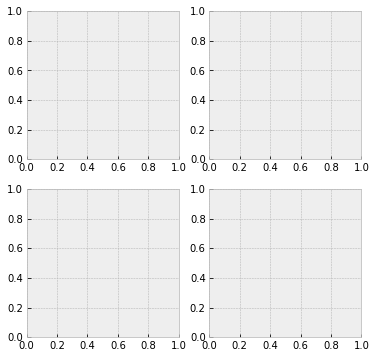

In [122]:
def plot_regression(x, y_mean, y_hpdi):
    print(x.shape)
    # Sort values for plotting by x axis
    # idx = jnp.argsort(x)
    # marriage = x[idx]
    ctrls = stat_data_dave[:, 0]
    print('ctrls.shape', ctrls.shape)
    case1 = stat_data_dave[:, 1]
    case2 = stat_data_dave[:, 2]
    caseBoth  = stat_data_dave[:, 3]
    
    
    meanCtrls = y_mean[:, 0]
    print('meanCtrls.shape', meanCtrls.shape)
    print("y_hpdi.shape", y_hpdi.shape)
    meanCtrls = y_mean[:, 1]
    meanCtrls = y_mean[:, 2]
    meanCtrls = y_mean[:, 3]
    hpdiCtrls = y_hpdi[:, 0]
    hpdiCases1 = y_hpdi[:, 1]
    hpdiCases2 = y_hpdi[:, 2]
    hpdiCasesBoth = y_hpdi[:, 3]

    # Plot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    ax.plot(ctrls, meanCtrls)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

random_key, _random_key = random.split(random_key)
t = best_chain.get_samples()
# test = {
#     'beta': t['beta'][0,:],
#     'dirichlet_concentration': t['dirichlet_concentration'][0,:],
#     'probs': t['probs'][0,:]}

prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, stat_data_dave,n_cases,n_ctrls,4)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)
ax = plot_regression(stat_data_dave, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Obs", ylabel="Divorce rate", title="Predictions with 90% CI");
# predictive = Predictive(model_with_gamma_prior_alpha8, t)


# samples_predictive = predictive(random.PRNGKey(1), stat_data_dave,n_cases,n_ctrls,4)

# mean_prior_pred = jnp.mean(samples_predictive, axis=0)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)
# # display(samples_predictive['z'].mean(0)[0:100])
# pd.DataFrame(np.array(samples_predictive['z'])[0], columns=['z']).to_csv("z_pred.tsv", sep='\t')
# display(np.array(samples_predictive['z'])[0:3])
# display(np.array(samples_predictive['obs'])[1999])
# posterior_samples = best_chain.get_samples()
# predictive = Predictive(model, posterior_samples=posterior_samples)
# samples = predictive(_random_key, *model_args)
# print(samples)

# weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])

# assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
# display(mean_df)

# PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))


# PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

# PD_V = PD_V_H_P_H_mean.sum(1)

# rr = PD_V[1:4]/PD
# display(rr)

In [270]:
from numpyro.infer.util import Predictive
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4
model_args = [run_params_dave['data'], run_params_dave['n_cases'], run_params_dave['n_ctrls'], run_params_dave['max_K']]
i = 0
while i < 20_000:
    i += 1
    
    random_key, _random_key = random.split(random_key)
    predictive = Predictive(new_school, best_chain.get_samples())
    samples_predictive = predictive(random.PRNGKey(1))
    print(np.mean(samples_predictive['obs'])) 
    posterior_samples = best_chain.get_samples()
    predictive = Predictive(model, posterior_samples=posterior_samples)
    samples = predictive(_random_key, *model_args)
    print(samples)

    weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])
    
    assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
    display(mean_df)
    
    PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))
    

    PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

    PD_V = PD_V_H_P_H_mean.sum(1)

    rr = PD_V[1:4]/PD
    display(rr)
    
    if i > 5:
        break

    # For a locus with two alleles, A1 and A2, with frequencies p and q.

    # alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
    # 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

    # alpha2 = -p * alpha1 /q

    # For case control data, if the prevalence of disease is Pv, then
    # the threshold on the liability scale is

    # thres =  Inv_Cumulatative_Normal( 1 - Pv)

    # If the penetrance of A1 is P{D | A1}. then 

    # alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

    # i..e alpha1 is the mean liability of individuals with an A1 allele.

    # alpha2 = -p*alpha / q

    # Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

    # Of course, with two phenotypes you can calculate the alphas independently
    # for the two traits based on the penetrance of the A1 allele for both traits.

    # For your problem, we can think of A1 is the collection of a bunch of 
    # rare alleles....

    # Assuming alpha is our rare allele marginal sums (per gene), across all samples:
#     P_D1_A1 = PD_V[1]
#     P_D2_A1 = PD_V[2]
#     print("P_D1_A1", P_D1_A1)
#     print("P_D2_A1", P_D2_A1)
#     q = 1e-4
#     p = 1-q

#     #Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
#     prevalence_d1 = PD[0]#.02
#     prevalence_d2 = PD[0] #.02
#     thresh1 = Inv_Cumulative_Normal(PD[1])
#     thresh2 = Inv_Cumulative_Normal(prevalence_d2)
#     print(f"thresh1: {thresh1}, thresh2: {thresh2}")

#     alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
#     alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

#     alpha2_D1 = -p*alpha1_D1/q
#     alpha2_D2 = -p*alpha1_D2/q

#     variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
#     variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
#     print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
#     print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

#     cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
#     print(f"cov: {cov}")

#     rho = cov / ((variance_D1*variance_D2)**.5)
#     print(f"rho: {rho}")
#     break

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H12,0.88,0.0460,0.067,0.0071
H0,0.95,0.0220,0.022,0.0014
H1,0.90,0.0660,0.025,0.0045
H2,0.92,0.0092,0.068,0.0013


array([  4.10336979,   1.76198302, 585.27549722])

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H12,0.88,0.0460,0.067,0.0071
H0,0.95,0.0220,0.022,0.0014
H1,0.90,0.0660,0.025,0.0045
H2,0.92,0.0092,0.068,0.0013


array([  4.10336979,   1.76198302, 585.27549722])

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H12,0.88,0.0460,0.067,0.0071
H0,0.95,0.0220,0.022,0.0014
H1,0.90,0.0660,0.025,0.0045
H2,0.92,0.0092,0.068,0.0013


array([  4.10336979,   1.76198302, 585.27549722])

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H12,0.88,0.0460,0.067,0.0071
H0,0.95,0.0220,0.022,0.0014
H1,0.90,0.0660,0.025,0.0045
H2,0.92,0.0092,0.068,0.0013


array([  4.10336979,   1.76198302, 585.27549722])

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H12,0.88,0.0460,0.067,0.0071
H0,0.95,0.0220,0.022,0.0014
H1,0.90,0.0660,0.025,0.0045
H2,0.92,0.0092,0.068,0.0013


array([  4.10336979,   1.76198302, 585.27549722])

{'obs': DeviceArray([[[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             ...,

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
              [30,  0,  1,  0],
              [34,  1,  1,  0],
              [46,  1,  1,  0]],

             [[29,  2,  1,  0],
              [30,  1,  0,  0],
              [47,  3,  1,  0],
              ...,
      

KeyboardInterrupt: 

In [64]:
!cat sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.1,0.1,0.1,0.2,0.2,0,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.2  h2[1] =0.2   rho = 0 

 Stupid_sum[0] = -6.53466991629159e-09   and stupid_sum[1] = 4.86649298636621e-09 

 Before normalization total variances were 0.861577101783085 and 0.83324292185757 

Normalizing by 0.481801251489393

 For disorder 0 we expected a prevalence of 0.02 and got 0.022515 with 4503 out of 200000

 Genetic mean liability  = 6.00374749915034e-16 Genetic Variance in Liabilty = 0.8578363607211
 Residual mean liability  = 0.00185293055314494 Residual Variance in Liabilty = 3.45258459054147
 Total mean liability  = 8.76720918085

In [315]:
# random_key, _random_key = random.split(random_key)
#P(H0|D) = P(D|H0)P(H0)
H0_posterior = (best_weights[0][:,assumed_h0] @ best_probs[0][:,assumed_h0]).mean(0).mean(0)
#P(H1|D) = P(D|H1)P(H1)


best_weights[0][:,assumed_h0].mean()

0.050556492

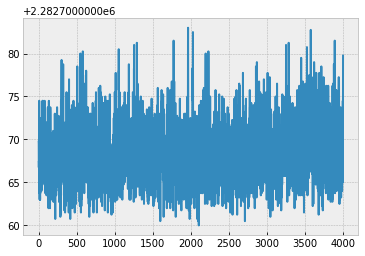

In [28]:
plt.plot(best_chain.get_extra_fields()['potential_energy'])

In [45]:
import pandas as pd
import numpy as np

df_exp2 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv')
# disorder 1, disorder 2, comorbid
pds_exp2 = np.array([0.03669,0.043745,0.00995])
pd_with_both_exp2 = np.array([1 - pds_exp2.sum(), *pds_exp2])
n_samples_exp2 = 200_000
n_cases_exp2 = n_samples_exp2 * pds_exp2
n_ctrls_exp2 = n_samples_exp2 - n_cases_exp2.sum()

display(df_exp2)

run_params_exp2 = {
    "data": df_exp2.to_numpy(),
    "n_cases": n_cases_exp2,
    "n_ctrls": n_ctrls_exp2,
    "max_K": 4,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "print_diagnostics": True,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp2 = run_until_enough(random_key=_random_key, run_params=run_params_exp2)
best_chain_exp2, statistics_exp2 = select_best_chain(res_exp2)
display(statistics_exp2)
# del res_exp2

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp2, best_probs_exp2, _, _ = get_parameters(best_chain_exp2)
# H_exp2, mean_df_exp2 = get_assumed_order_for_2(best_probs_exp2, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
# best_weights_exp2, best_probs_exp2, best_betas_exp2, best_dirichlet_concentrations_exp2 = ordered_statistics([best_chain_exp2], order=H_exp2)

print(H_exp2)
display(mean_df_exp2)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,1,4,0
1,41,1,0,0
2,37,1,2,0
3,31,2,6,1
4,42,1,2,1
...,...,...,...,...
19995,29,0,1,1
19996,39,1,0,1
19997,28,0,3,0
19998,36,2,1,0


sample: 100%|██████████| 6000/6000 [00:22<00:00, 271.82it/s, 7 steps of size 4.70e-01. acc. prob=0.88] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.03      0.04   4672.66      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05   5124.54      1.00
                   beta[2]      0.95      0.00      0.95      0.95      0.96   5033.34      1.00
dirichlet_concentration[0]      5.76      1.00      5.72      4.05      7.31   5660.09      1.00
dirichlet_concentration[1]      0.90      0.36      0.85      0.33      1.45   5619.37      1.00
dirichlet_concentration[2]      0.78      0.32      0.75      0.30      1.27   6860.64      1.00
dirichlet_concentration[3]      0.59      0.26      0.55      0.18      0.98   5937.94      1.00
                probs[0,0]      0.77      0.00      0.77      0.76      0.77   5240.65      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   6274.85      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.03726789 0.04270044 0.8772126  0.04281908]
probs.mean(0) [[0.7665787  0.01661861 0.18965995 0.02714279]
 [0.73062235 0.23055968 0.01327962 0.02553842]
 [0.9272753  0.03450041 0.02787874 0.01034554]
 [0.65153867 0.14767732 0.09971422 0.10106983]]


sample: 100%|██████████| 6000/6000 [00:23<00:00, 255.34it/s, 7 steps of size 5.69e-01. acc. prob=0.85] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   6003.72      1.00
                   beta[1]      0.92      0.00      0.92      0.91      0.92   5839.01      1.00
                   beta[2]      0.53      0.01      0.53      0.51      0.56   6526.27      1.00
dirichlet_concentration[0]      5.74      0.97      5.68      4.11      7.23   6806.40      1.00
dirichlet_concentration[1]      0.89      0.36      0.85      0.30      1.45   7578.87      1.00
dirichlet_concentration[2]      0.77      0.31      0.74      0.28      1.25   7670.09      1.00
dirichlet_concentration[3]      0.59      0.26      0.55      0.19      0.97   8510.22      1.00
                probs[0,0]      0.65      0.00      0.65      0.65      0.66   7566.85      1.00
                probs[0,1]      0.15      0.00      0.15      0.14      0.15   7729.78      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.04295688 0.8773158  0.04261095 0.03711754]
probs.mean(0) [[0.65165895 0.14769037 0.09966298 0.1009877 ]
 [0.92727387 0.03450007 0.02788184 0.01034431]
 [0.73060787 0.2306341  0.01323438 0.0255237 ]
 [0.76644045 0.01661618 0.18980089 0.0271425 ]]


sample: 100%|██████████| 6000/6000 [00:22<00:00, 267.31it/s, 7 steps of size 4.88e-01. acc. prob=0.88] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.88      0.00      0.88      0.87      0.88   4966.25      1.00
                   beta[1]      0.35      0.01      0.35      0.33      0.37   5073.82      1.00
                   beta[2]      0.47      0.01      0.47      0.44      0.49   5171.31      1.00
dirichlet_concentration[0]      5.74      0.99      5.69      4.16      7.37   5855.36      1.00
dirichlet_concentration[1]      0.89      0.36      0.85      0.32      1.44   6295.03      1.00
dirichlet_concentration[2]      0.78      0.33      0.73      0.29      1.30   5635.44      1.00
dirichlet_concentration[3]      0.59      0.26      0.56      0.20      0.99   5237.74      1.00
                probs[0,0]      0.93      0.00      0.93      0.93      0.93   5758.02      1.00
                probs[0,1]      0.03      0.00      0.03      0.03      0.03   6365.45      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.87739706 0.04292541 0.03718669 0.04249005]
probs.mean(0) [[0.9272747  0.03450457 0.02787708 0.01034367]
 [0.6516862  0.14770387 0.09962405 0.10098597]
 [0.76654655 0.01662675 0.18969554 0.02713121]
 [0.7305203  0.23075804 0.01321887 0.02550276]]


sample: 100%|██████████| 6000/6000 [00:23<00:00, 255.14it/s, 7 steps of size 5.02e-01. acc. prob=0.87] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   5492.81      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05   6202.62      1.00
                   beta[2]      0.96      0.00      0.96      0.96      0.96   5085.94      1.00
dirichlet_concentration[0]      5.75      0.98      5.71      4.22      7.39   5638.16      1.00
dirichlet_concentration[1]      0.90      0.37      0.86      0.33      1.47   6974.27      1.00
dirichlet_concentration[2]      0.79      0.32      0.75      0.27      1.28   6211.83      1.00
dirichlet_concentration[3]      0.58      0.26      0.55      0.19      0.99   6258.82      1.00
                probs[0,0]      0.73      0.00      0.73      0.73      0.74   6450.80      1.00
                probs[0,1]      0.23      0.00      0.23      0.23      0.24   4925.13      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.884214,0.114179,2300056.50,0.0
2,0.0,0.879814,0.118986,2300050.75,2.0
3,0.0,0.874223,0.122047,2300059.50,3.0
1,0.0,0.851586,0.138447,2300054.25,1.0


[2 3 1 0]


,"P(~D|V,H)","P(D2|V,H)","P(D1|V,H)","P(D12|V,H)"
H12,0.65,0.150,0.100,0.100
H2,0.73,0.230,0.013,0.026
H0,0.93,0.035,0.028,0.010
H1,0.77,0.017,0.190,0.027


In [ ]:
best_weights_exp2, best_probs_exp2, _, _ = get_parameters(best_chain_exp2)
best_weights_exp2.mean(0)

array([0.03726789, 0.04270044, 0.8772126 , 0.04281908], dtype=float32)

In [69]:
H_exp2, mean_df_exp2 = get_assumed_order_for_2(best_probs_exp2, pd_with_both_exp2, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
mean_df_exp2

,"P(~D|V,H)","P(D2|V,H)","P(D1|V,H)","P(D12|V,H)"
H1,0.766579,0.016619,0.189660,0.027143
H2,0.730622,0.230560,0.013280,0.025538
H0,0.927275,0.034500,0.027879,0.010346
H12,0.651539,0.147677,0.099714,0.101070


In [70]:
# this looks correct in order
display('best_probs sample mean',best_probs_exp2.mean(0))
display('best_probs sample mean', best_weights_exp2.mean(0))


'best_probs sample mean'

DeviceArray([[0.7665787 , 0.01661861, 0.18965995, 0.02714279],
             [0.73062235, 0.23055968, 0.01327962, 0.02553842],
             [0.9272753 , 0.03450041, 0.02787874, 0.01034554],
             [0.65153867, 0.14767732, 0.09971422, 0.10106983]],            dtype=float32)

'best_probs sample mean'

array([0.03726789, 0.04270044, 0.8772126 , 0.04281908], dtype=float32)

In [76]:
print("H_exp2", H_exp2)

print("best_weights.mean(0)", best_weights_exp2.mean(0))

print("best_weights.mean(0)[H]", best_weights_exp2.mean(0)[H_exp2])


print("\nbest_probs.mean(0)", best_probs_exp2.mean(0))
print("best_probs.mean(0)[H]", best_probs_exp2.mean(0)[H_exp2])

PD_V_H_P_H_across_samples = np.multiply(best_probs_exp2, best_weights_exp2.reshape(*best_weights_exp2.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H_exp2])
        
PD_V = PD_V_H_P_H_mean[H_exp2].sum(1)
display("PD|V", PD_V)
PD = pds_exp2
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

H_exp2 [2 0 1 3]
best_weights.mean(0) [0.03726789 0.04270044 0.8772126  0.04281908]
best_weights.mean(0)[H] [0.8772126  0.03726789 0.04270044 0.04281908]

best_probs.mean(0) [[0.7665787  0.01661861 0.18965995 0.02714279]
 [0.73062235 0.23055968 0.01327962 0.02553842]
 [0.9272753  0.03450041 0.02787874 0.01034554]
 [0.65153867 0.14767732 0.09971422 0.10106983]]
best_probs.mean(0)[H] [[0.9272753  0.03450041 0.02787874 0.01034554]
 [0.7665787  0.01661861 0.18965995 0.02714279]
 [0.73062235 0.23055968 0.01327962 0.02553842]
 [0.65153867 0.14767732 0.09971422 0.10106983]]

PD_V_H_P_H_mean [[2.8570104e-02 6.1952719e-04 7.0666289e-03 1.0115323e-03]
 [3.1199185e-02 9.8433169e-03 5.6734763e-04 1.0906139e-03]
 [8.1341738e-01 3.0264230e-02 2.4455685e-02 9.0752607e-03]
 [2.7899677e-02 6.3231788e-03 4.2691818e-03 4.3270597e-03]]
ordered PD|Vs based on H [[8.1341738e-01 3.0264230e-02 2.4455685e-02 9.0752607e-03]
 [2.8570104e-02 6.1952719e-04 7.0666289e-03 1.0115323e-03]
 [3.1199185e-02 9.8433169e-03

'PD|V'

array([0.8772126 , 0.03726779, 0.04270046, 0.0428191 ], dtype=float32)

'rr'

array([1.01574797, 0.97612212, 4.3034269 ])

In [ ]:
import numpyro.distributions as dist
# order doesn't matter for mixture models
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):

        mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))

        component_dist = dist.Multinomial(probs=probs.mean(1).mean(0))

        mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

        res = mixture.log_prob(run_params_exp2_with_conc['data'])
        print("done:", res.sum())
        print(res)

We have 4 different categories of states
With probability pi_1 (disease 1 affected by gene), the gene affects disease 1. we have individuals affected by gene 1 with penetrance P(D|A1). Individuals affected by both also get P(D|A1), I think

With probability pi_2 (disease 2 affected by gene), the gene affects disease 2. we have individuals affected by disease 2 with penetrance P(D|A2). Individuals affected by both also get P(D|A2), I think

With probability pi_3, diseases 1 and 2 affected by the gene. Individuals with disease 1, 2, and both get P(D|ABoth), I think. 

I think we keep all penetrances independent.

I think that we actually get P(V|D1)?

In [ ]:
samples = np.array([n_ctrls, *n_cases])
sample_proportions = samples / samples.sum()
sample_proportions

penetrances = inferred_params_davec[0]['probs'].mean(0) / sample_proportions
print(penetrances)

# Dude this isn't penetrance! From  cureffi.org:
#P(D|A) = P(D) * P(A|D)/P(A)
# where p(A|D) = allele frequency in cases
# where P(A) is the allele frequency in population controls
# and
# penetrance = baseline risk * case allele frequency / population control allele frequency

# and the in-sample estimate of P(D) is the number of cases / total number of samples

# so when we get something like
# [[ 0.8134461   0.32360843  5.0985327   2.520728  ]
#  [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
#  [ 0.80601496  5.306168    0.31114104  2.587026  ]
#  [ 0.69068795  2.8604672   2.904822   10.298759  ]]
# we can see that we've estimated say for component 2 that case allele frequency / population control allele frequency is larger
# penetrance = rr * P(D|~V) as well
# and P(D) = P(D|V)P(V) + P(D|~V)P(~V)
# population control allele frequency = P(A) = P(V|~D)

# P(D|V) / ( P(D|V)P(V) + P(D|~V)P(~V)) = P(V|D) / P(V|~D)

# P(V|D)P(D) = P(D|V)P(V)
# P(V|D) = P(D|V)P(V)/P(D)

# so my above calculation is close to P(V|D), off by the allele frequency

[[ 0.8134461   0.32360843  5.0985327   2.520728  ]
 [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
 [ 0.80601496  5.306168    0.31114104  2.587026  ]
 [ 0.69068795  2.8604672   2.904822   10.298759  ]]


In [ ]:
# alpha1 = thres = Invs_Cumulative_Normal( 1 - Pv )
# Pv = prevalence of disease 1
# 0.04295 is prevalence of disease 1

# Why isn't this working?
samples = [n_ctrls, **n_cases]
d = dist.Normal(0, 1)

# for disease2 the penetrance should be the thing that is highest, after scaling by sample proportion I think for in
# we expect a pattern 
thresh1 = None
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    pd1 = .04295
    thresh1 = d.icdf(1-.04295)

    alpha1 = thresh1 - 

In [ ]:
stat_data_dave

# Prevalence of disease 1
# = 

concentration_a1 = inferred_params_davec[0]['concentrations'].mean(0)[0]

add_them = []
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for i in range(20_000):
        prob = numpyro.sample(f'prob_gene_{i}', dist.Dirichlet(concentration_a1))
        add_them.append(prob)
        

        if i < 5:
            print(prob)

np.array(add_them).mean(0)
stat_data_dave.mean(0)

array([35.8165 ,  1.7329 ,  1.69305,  0.75755])

In [ ]:
# P(D|~V) = P(D|~V)P(~V)
# P(D) = Sum( P(D|V)P(V) ) over all V, which are the architectures (rare allele count sums)
# P(D|~V) this is prevalence as well? It can't be, must be 1 - sum (P(D|V)P(V)) over everything other than ~V, then / P(~V)
# P(V|D) = P(D|V)P(V) / P(D)
# pdv_pv_null = probs.mean(0)[selected_components]
# 
# alpha1 = freq(a1a1) * average(phenotype of a1a1 invididulal) + .5 * freq(a1a2) * average(phenotype of a1a2 individuals)/p

# alpha2 = -p * alpah1 / q
# alpha1 = thres - inv_cum_normal( 1 - P(D|A1))

# alpah2 = -p*alpha / q
# Variance due to locus is 2*(p*alpah1^2 + q*alpha2)

# For 2 phenotypes, you can calculate the alphas independently for the two traits based on the pentrance of the a1 allele for both traits (a1 allele here is a collection of rare alleles)

# penetrance is P(D|V), or here, P(D|A12) I think

multinomial_probs = probs.mean(0)[selected_components]
multinomial_probs
# The probability at a locus in P(D|V) = P(V|D)P(D)/P(V)
# dv_pv_one = probs.mean(1)[selected_components]
# dv_pv_other = probs.mean(2)[selected_components]
# dv_pv_both = probs.mean(3)[selected_components]
# dv_pv_both
null = multinomial_probs[0,:]
print('null', null)
a1 = multinomial_probs[1,:]
print('a1', a1)
a2 = multinomial_probs[2,:]
print("a2", a2)
a12 = multinomial_probs[3,:]
print("a12", a12)

# these are the proportions of genes that are configured in each way
# are these P(D)? are these P(V)?
# Well, the full likelihood is P(D) = P(D|V)P(V) + P(D2|V)(P|V) + P(D12|V)P(V) right? or is P(V|D)

print("pis", weights.mean(0))

In [ ]:
# 0.00010000000000000002
print('(stat_data_dave/ (200_000 * 2)).mean(0).sum()', (stat_data_dave/ (200_000 * 2)).mean(0).sum())

# array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])
# These are P(V|D) and P(D) is pi?
# No, I think these are P(V|D)P(D) so that their sum, is P(V)
(stat_data_dave/ (200_000 * 2)).mean(0)

In [ ]:
# Ok, let's assume that this is true, then P(V|D)P(D) summed is P(V)
# well, since null * 1e-4 gives numbers very close to N*2, it's probably P(D|V)
# So we are estimating penetrance
print('null * 1e-4: ', (null * 1e-4).sum())
# If so then this is P(D|V)P(V); then pi is P(H1 (H1 affects disease 1)), and maybe the P(V) P(D|V) means probability of disease given the variat affects disease 1 (It's really P(D|V,H1))

# Dave wrote that alphas can be calculated based on the penetrance of the a1 allele for both traits
# we estimate the penetrance of the a1 allele for both traits in the a12 component
#alpha1 = thres - inv_cum_normal( 1 - P(D|A1))
# assuming he means A12, let's use a12, which is P(D|a12)
# I think it may be more appropriate to just recognize that P(D|A1) = P(D|A1, H1)P(H1) + P(D|A1, H12)P(H12)
penetrance_d1_given_a1 = a1 * weights[1]
print('penetrance_d1_given_a1', penetrance_d1_given_a1)

penetrance_d1_given_a1_smear = a1 * (weights[1] / weights.sum()) + a12 * (weights[3] / weights.sum())
print('penetrance_d1_given_a1_smear', penetrance_d1_given_a1_smear)
print('weights shape', weights.shape)
print("probs.shape", probs.shape)
print('probs[0]', probs[0])
full_smear2 = (probs * weights).mean(0)
print("full_smear", full_smear2)

# P(D1|V) = P(D1|V1)P(V1) + P()
# I don't know if it's the 2nd entry, or 2nd + 4th that's needed
# Let's just say it's P(D1|V)
penetrance_d1_smear = full_smear2[1][1]
print('penetrance_d1_smear', penetrance_d1_smear)

penetrance_d1 = a1[1]
print(penetrance_d1)

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)

probs = inferred_params_dave[0]['probs']
print(probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

(1001, 4)
(4,)
[0.8703473  0.08080296 0.04035727 0.01082029]
(DeviceArray([0, 1, 2, 3], dtype=int32),)
[0.941305 0.033235 0.023975 0.001485]


DeviceArray([[0.9435869 , 0.02272266, 0.03207771, 0.00161274],
             [0.7790772 , 0.01889851, 0.19474554, 0.00727887],
             [0.87157816, 0.09131201, 0.03188112, 0.0052288 ],
             [0.62226677, 0.04246676, 0.31265846, 0.02260807]],            dtype=float32)

In [ ]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))